# Introduction
In this writeup I'll strive to provide insight into my methods, but without giving away model details that could be profitable for the host. When a good financial indicator becomes common knowledge, everyone uses it, therefore it loses profitability. As such, I won't be sharing my code or any specific insight on features.

I decided to enter this competition because it concerns asset price prediction using actual market data (not pre-engineered features). That's the kind of data I like: having an explicit time dimension, many interacting entities, a lot of noise, and a need for creative method development. In 2014-2017, I researched stock price analysis and prediction in my own time. It didn't end up being profitable long-term as a single DIY investor, but I did learn a lot about predicting time series and asset prices.

# Toolkit
My toolkit consisted of CPython, Numba, Jupyter, Pandas, LightGBM, Matplotlib, and scikit-learn. Using the Numba compiler instead of CPython for feature generation resulted in high performance. Doing so, I was able to experiment with a wide variety of features, utilizing the entire dataset and iterating quickly.

# Cross validation
Setting up good N-fold cross validation (CV) is essential. We should try to see if our ideas fail in the most real environment we can make. Every time we have a research question, it should (eventually, after a period of creative exploration) be answered in that manner. If we don't have a good CV setup, our decisions will mostly be mere guesses. Good N-fold CV is easy to set up, taking less than 100 lines of code, without using scikit-learn or any timeseries framework.

In this competition I used 6-fold, walk-forward, grouped cross validation. The group key was the timestamp. In a typical setup, train folds were 40 weeks long, test folds were 40 weeks long, there was a gap of 1 week between test and train folds, and the ends of training folds were incremented by 20 weeks each fold.

I chose to overlap my folds so that they could be long, but I could still have 6 folds. With non-overlapping folds, I would have to decide between many short folds or a few long ones.

The advantage of having many folds is that average CV scores will have lower variance. On the other hand, the advantage of having long folds is that the model sees more data, so you get a better picture of how it will perform with the full dataset. Instead of choosing between many short folds or a few long ones, I let them overlap so I could have many long folds. I could have used more than 6 folds, or run CV multiple times, changing seeds. I didn't do these things because CV score variance was decently low, and CV was already almost too slow.

(If you don't pay attention to CV variance, you could waste days optimizing your model, only to find that your early decisions were based on noise and incorrect. An easy way to see if your CV scores have too much variance is to look at a plot of CV score vs. a parameter you're tuning. A good plot will usually be smooth, with a knee and a plateau, or maybe a peak or a valley. If the plot looks too noisy to clearly see those things, then try it again, with different seeds, and see if you get different results. If you do, then your CV results are too noisy. You can try using more folds, or running CV several times with different random seeds and averaging.)

The one week gap between train and test data was to prevent CV results from being too rosy. With no gap, a model can cheat at the the beginning of the test period, because the end of the train period is very similar. There was no gap between train and test data in the final submission.

# Public leaderboard scores
As I was developing my model, naturally I wanted to have an idea of how it would place against competitors. Because public leaderboard scores were unrealistically high due to probing and overfitting, I had to find a way to interpret them. So I looked at masters and grandmasters with "low" scores. I figured these competitors were good enough to submit good kernels, but had been careful to keep the public leaderboard period out of their training data. I did not expect true scores to go above 0.1, based on experience and discussions here. Plotting the sorted scores of the "low" scoring masters and grandmasters, there was a clear plateau around 0.08, as I recall. That was the score I aimed to beat in my local CV.

Of course, I did not use the public leaderboard as a guide in any optimizations. That's always a bad idea (see the paragraph above about CV variance). I only made a total of two submissions in the competition.

# Feature engineering
Because my labor and computational resources are finite, it’s important to know where to direct them. As I developed my model, feature engineering was guided by feature importance. As I made new features, I focused further effort on developing features sets that already performed well (had high importance), or for which transformations led to easy increases in importance.

As I said in the introduction, I won't be discussing specific feature insight or give my code. I'll only be giving my two cents on methods.

# Learner
The learner was trivial: a LightGBM GBDT regressor with squared loss. There was no ensembling other than the gradient boosting in GBDT. The only parameters I changed from defaults were the number of estimators, number of leaves, and the learning rate. There was no regularization, augmentation, or feature neutralization. I checked with CV whether these things would help, found that they wouldn't, and decided to go with a simpler submission.

LightGBM parameters were not tuned exhaustively. Tuning was taking a long time, and CV results were indicating that regularization would have little effect on model performance. So I decided to not push on that wall and instead placed my focus back on feature engineering. CV is essential in making these resource allocation decisions.

# Submission kernel
Because this was a code competition with a large dataset, performance was crucial. Our kernels were limited to running in 9 hours or less, using up to 16GB of RAM. As we all can attest, it's easy to bump into those limits.

The hardest limitation I dealt with was the 16GB RAM limit. I wanted to train with the entire dataset, because CV had shown me that scores just kept improving with longer training data. To use the entire dataset, I had to find and fix code that resulted in unnecessary RAM copies of arrays. The Pandas operation df.update() was a frustrating offender. The solution was to select small subsets of data, use df.update() on those subsets, then append to a list of dataframes, and then at the end, concatenate the list into one dataframe.

On the other hand, my kernel is really fast. It takes 25 minutes to import data, generate features, and train the model. When submitting, predictions are generated at a rate of about 50 timestamps per second, not including the overhead of the submission mechanism. Generating predictions for 2 weeks of data takes around 10 minutes, on top of the the 25 minutes to train the model.

Speed wasn't a limiting factor in my submission because I used Numba to write feature generation code and my learner was simple. My main goal was to have a codebase that allowed me to test feature ideas quickly and easily. The fast submission kernel was a side effect.

# Inconsistency Findings

Note: In this notebook,***G-Research Tutorial***. All the efforts to recreate the Target in the training data has allowed us to infer how G-Research actualy calculates the target (it's not the same as the G-Research Tutorial). I will refer to the methodoloy G-Research uses to calculate the Target in the traning data as the ***Target-Methodology***.

1. ***Padding for Missing Data(rows)***:
Padding for missing rows is a best practcie when handling time series, especially for this competition where we are trying to calculate market-returns over the next 15 mins. In G-Research Tutorial missing rows are padded with previous available rows :eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='**pad**'). However, the target provided in the training data seems to be calculated using NaN for padding. 

2. ***Beta = 0***:
As a result from padding with NaN (mentioned in above finding), the *Target-Methodology* calculates beta=0 if either the next minute or the next 16th minute is missing (NaN). This is a pretty unrealistic way to calculate beta in my opinion. Beta is supposed to represent a type of correlation between a given asset and the market. Missing data or simply no trade during a period, doesn't mean the correlation with market is 0 for that period. If we set beta=0 for these periods, the beta time sereis will not be smooth. Please see plot below for Asset_ID = 5.
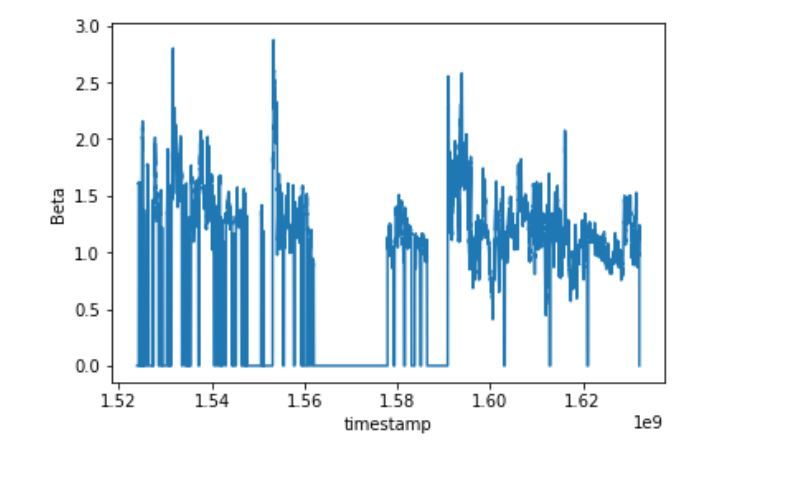

I think a better way to handle this is to follow the G-Research Tutorial, where we pad missing rows with previous avaible rows. In that case, stock price will be smooth and beta will be less noisy without the random discontious jumps to 0. The *Target-Methodology* approach to calculate beta will not result in an accurate measure of asset specific return.

3. ***Market-Return Calculation Not Ideal***:
Based on G-Research Tutorial, market-return is calculated as follows: $$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}$$ 
R^a refers to log-return for an asset, which is calculated as follows: $$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$ 
Let's look at this following case. Assume real world log-returns are constant from time-2 to time-4 for Asset1, Asset2 and Asset3. Simply assume beta = 1 and all three assests are equally weighted. However, in training data, log-return for Asset2 at time-3 is missing. If we follow G-Research Tutorial's approach to pad missing rows, there will not be any missing prices (no NaN log-returns), target should look like below:
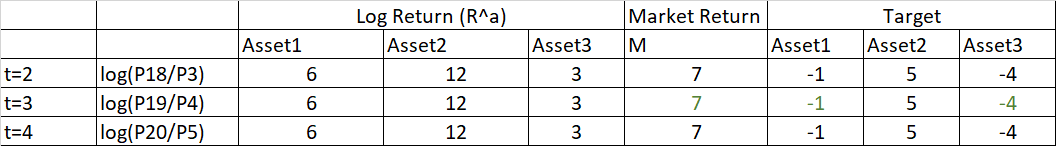

Lets take a look at the same case but with the *Target-Methodology*. We will have a NaN log-return for Asset2 at time=3.
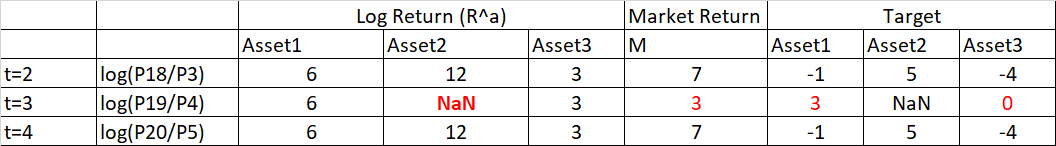

As you can see, becuase of the NaN for Asset2, market-return has changed significantly. This is because in the *Target-Methodology*, the market-return treats NaN as 0 and averages over all assets (instead of averaging over only the non NaN assets). This approach is strange because a NaN log-return in Asset2 results in Asset1's and Asset3's target value to swing unpredictably. 

# Summary

Based on what we have inferred about the *Target-Methodology*, both the beta and market-return have random jumps based on whether or not there is missing price data in the future(15 mins period future). If the scoring process calculates the Target using the *Target-Methodology*, in order for our models to correctly predict the Target, our models needs to predict whether or not there will be missing data for each asset in the future. It is unlikely that there is any pattern in when missing data occurs. Predicting missing data may not be impossible but seems very difficult to do using the features in the training data. 
 
To summarize,the *Target-Methodology* G-Research uses makes training a high-scoring model difficult. Moreover, the prediction from this model might match the (strangely calculated) Target but won't match the actual returns from the crypto market. All of above problems can be simply solved if the Target we are trying to predict calculated based on G-Research Tutorial (padding missing data with previous available row instead of padding with NaN).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

data = pd.read_csv(r"../input/g-research-crypto-forecasting/train.csv")
asset_details = pd.read_csv(r"../input/g-research-crypto-forecasting/asset_details.csv")

asset_df_Dict = {}
Asset_IDs = asset_details.Asset_ID.to_numpy()
asset_details['Normalized_Weight'] = asset_details['Weight'] / asset_details['Weight'].sum()

all_timestamps = np.sort(data['timestamp'].unique())
##insert January 1, 2018 12:00:00 to all_timestamps to better match the target.
all_timestamps = np.insert(all_timestamps, 0, 1514764800, axis=0)

In [2]:
for i in Asset_IDs:
    data_asset_i = data[data['Asset_ID']==i].copy()

    ##calculate Return for each timestamp
    data_asset_i.sort_values(by = 'timestamp', inplace = True)
    data_asset_i.set_index('timestamp', inplace = True)
    
    data_asset_i = data_asset_i.reindex(all_timestamps)
    
    data_asset_i['P1'] = data_asset_i.shift(periods=-1)['Close']
    data_asset_i['P16'] = data_asset_i.shift(periods=-16)['Close']
    data_asset_i['Log_Return'] = (data_asset_i['P16']/data_asset_i['P1'])-1
    
    weight_i = asset_details[asset_details['Asset_ID']==i]['Normalized_Weight'].iloc[0]
    data_asset_i['Weighted_Log_Return'] = (data_asset_i['Log_Return']) * weight_i
    asset_df_Dict[i] = data_asset_i

In [3]:
market_return = asset_df_Dict[Asset_IDs[0]]['Weighted_Log_Return']

for i in Asset_IDs[1:]:
    market_return = market_return.add(asset_df_Dict[i]['Weighted_Log_Return'], fill_value = 0)

for i in Asset_IDs:
    asset_df_Dict[i]['Market_Return'] = market_return
    
    num = pd.DataFrame(asset_df_Dict[i]['Log_Return'] * asset_df_Dict[i]['Market_Return']).rolling(3750).mean().values  #numerator of linear regression coefficient
    denom = pd.DataFrame(asset_df_Dict[i]['Market_Return']*asset_df_Dict[i]['Market_Return']).rolling(3750).mean().values  #denominator of linear regression coefficient
    beta = np.nan_to_num( num / denom, nan=0., posinf=0., neginf=0.)  #if regression fell over, use beta of 0
    asset_df_Dict[i]['Beta'] = beta
    asset_df_Dict[i]['Re_Calc_Target'] = asset_df_Dict[i]['Log_Return'] - (asset_df_Dict[i]['Beta'] * asset_df_Dict[i]['Market_Return'])
    
    original_timestamp= np.sort(data[data['Asset_ID']==i].timestamp.unique())
    asset_df_Dict[i] = asset_df_Dict[i].reindex(original_timestamp)
    
    asset_df_Dict[i]['Abs_Diff'] = np.absolute(asset_df_Dict[i]['Re_Calc_Target'] - asset_df_Dict[i]['Target'])

In [4]:
for i in Asset_IDs:
    print(f'Asset_ID: {i}:')
    print(f'Average absolute error {asset_df_Dict[i].Abs_Diff.mean()}')
    print(f'Max absolute error {asset_df_Dict[i].Abs_Diff.max()}')
    print()

Asset_ID: 2:
Average absolute error 6.026568783288828e-16
Max absolute error 4.100192407818781e-14

Asset_ID: 0:
Average absolute error 4.880965206109951e-16
Max absolute error 3.8833519733216804e-14

Asset_ID: 1:
Average absolute error 7.684667534591603e-16
Max absolute error 5.293215952356656e-14

Asset_ID: 5:
Average absolute error 7.412548811749891e-16
Max absolute error 5.2985393850235596e-14

Asset_ID: 7:
Average absolute error 3.4229666963815347e-16
Max absolute error 2.676331378737018e-14

Asset_ID: 6:
Average absolute error 6.691847733335121e-16
Max absolute error 3.156676309234996e-14

Asset_ID: 9:
Average absolute error 8.642115658003641e-16
Max absolute error 5.97837751525887e-14

Asset_ID: 11:
Average absolute error 1.3818057708318612e-16
Max absolute error 1.827704654289164e-14

Asset_ID: 13:
Average absolute error 1.6428927623540302e-15
Max absolute error 6.390721285498557e-14

Asset_ID: 12:
Average absolute error 7.402031266515e-16
Max absolute error 5.6581963506913135e

Text(0, 0.5, 'Beta')

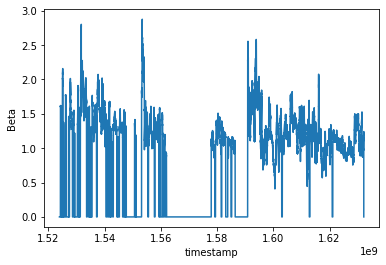

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

p = plt.plot(asset_df_Dict[3].Beta.index, asset_df_Dict[3].Beta.values)
plt.xlabel("timestamp")
plt.ylabel("Beta")